In [336]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prithviai/raw/test/phone/gyro/data_1626_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1631_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1627_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1624_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1632_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1621_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1622_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1623_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1629_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1628_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1630_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1625_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1620_gyro_phone.txt
/kaggle/input/prithviai/raw/test/phone/gyro/data_1633_gyro_phone.txt
/kaggle/input/prithviai/raw/test/p

In [355]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from scipy import stats
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import joblib

In [338]:
config_info = {
    'train_folder': '/kaggle/input/prithviai/raw/train/',
    'test_folder': '/kaggle/input/prithviai/raw/test/',
    'result_file': 'result.csv',
    'epoch': 70,
    'lr': 0.003,
    'batch_size': 128,
    'momemtum': 0.9
}

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [339]:
encode = LabelEncoder()
gen_file = np.loadtxt("/kaggle/input/prithviai/raw/train/phone/accel/data_1600_accel_phone.txt", delimiter=',',dtype = np.str)
lab = gen_file[:, 1]
encode.fit(lab)

LabelEncoder()

In [340]:
def give_data(file):
    arr_file = np.loadtxt(file, delimiter=',',dtype = np.str)
    y = arr_file[:, 1]
    x = arr_file[:, 3:]
    segments = []
    labels = []
    for i in range(0, x.shape[0]-180, 100):
        seg = x[i:i+180]
        segments.append(seg)
        label = stats.mode(y[i:i+180])[0][0]
        labels.append(label) 

    stac = np.asarray(segments)
    stac[:, :, 2] = np.array([[i[:-1] for i in j] for j in stac[:, :, 2]])
    
    labels = encode.transform(labels)
    return np.asarray(stac, dtype=np.float32), np.asarray(labels, dtype=np.int)

In [341]:
def preprocess_data(folder):

    phone_gyro = os.listdir(folder+"phone/"+"gyro/")
    phone_accel = os.listdir(folder+"phone/"+"accel/")
    watch_gyro = os.listdir(folder+"watch/"+"gyro/")
    watch_accel = os.listdir(folder+"watch/"+"accel/")

    final_data = None 
    final_label = None
    count=0
    for root in zip(phone_gyro, phone_accel, watch_gyro, watch_accel):
        pg_data = give_data(folder+"phone/"+"gyro/"+root[0])
        pa_data = give_data(folder+"phone/"+"accel/"+root[1])
        wg_data = give_data(folder+"watch/"+"gyro/"+root[2])
        wa_data = give_data(folder+"watch/"+"accel/"+root[3])
        row = min(pg_data[1].shape[0], pa_data[1].shape[0], wg_data[1].shape[0], wa_data[1].shape[0])
        final = np.stack((pg_data[0][:row], pa_data[0][:row], wg_data[0][:row], wa_data[0][:row]), axis=-1).reshape((-1, 180, 12))
        labula = np.stack((pg_data[1][:row], pa_data[1][:row], wg_data[1][:row], wa_data[1][:row]), axis=-1)
        labula = stats.mode(labula, axis=1)[0]
        if final_data is None:
            final_data = final
            final_label = labula
        else:
            final_data = np.concatenate((final_data, final))
            final_label = np.concatenate((final_label, labula))
            
    return final_data, final_label


In [342]:
class get_dataset(Dataset):
    def __init__(self, samples, labels, transform):
        self.samples = samples
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.transform:
            return self.transform(sample), target
        else:
            return sample, target

    def __len__(self):
        return len(self.samples)

In [343]:
x_train, y_train = preprocess_data(config_info["train_folder"])
x_test, y_test = preprocess_data(config_info["test_folder"])

In [328]:
# def normalize(x):
#     x_min = x.min(axis=(0, 2, 3), keepdims=True)
#     x_max = x.max(axis=(0, 2, 3), keepdims=True)
#     x_norm = (x - x_min) / (x_max - x_min)
#     return x_norm

In [329]:
# x_train, x_test = x_train.reshape((-1, 12, 1, 180)), x_test.reshape((-1, 12, 1, 180))
# x_train, x_test = normalize(x_train), normalize(x_test)

In [344]:
x_train, x_test = x_train.reshape((-1, 12, 1, 180)), x_test.reshape((-1, 12, 1, 180))
train_set = get_dataset(x_train, y_train, None)
test_set = get_dataset(x_test, y_test, None)
train_loader = DataLoader(train_set, batch_size=config_info["batch_size"], shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=config_info["batch_size"], shuffle=False)

In [345]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=32, kernel_size=(1, 12)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 12)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2)
        )  
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=64 * 36, out_features=1000),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=1000, out_features=500),
            nn.ReLU()
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=500, out_features=18)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(-1, 64 * 36)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = F.softmax(out, dim=1)
        return out

In [346]:
net = Network()

In [347]:
result = []
def train(model, optimizer, train_loader, test_loader):
    n_batch = len(train_loader.dataset) // config_info['batch_size']
    criterion = nn.CrossEntropyLoss()

    for e in range(config_info['epoch']):
        model.train()
        correct, total_loss = 0, 0
        total = 0
        for index, (sample, target) in enumerate(train_loader):
            sample, target = sample.to(DEVICE).float(), target.to(DEVICE).long()
            target = torch.squeeze(target)
            sample = sample.view(-1, 12, 1, 180)
            output = model(sample)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum()
#             if index % 20 == 0:
#                 print('Epoch: [{}/{}], Batch: [{}/{}], loss:{:.4f}'.format(e + 1, config_info['epoch'], index + 1, n_batch, loss.item()))
        acc_train = float(correct) * 100.0 /(config_info['batch_size'] * n_batch)
        print('Epoch: [{}/{}], loss: {:.4f}, train acc: {:.2f}%'.format(e + 1, config_info['epoch'], total_loss * 1.0 / n_batch, acc_train))
        # Testing
        model.train(False)
        with torch.no_grad():
            correct, total = 0, 0
            for sample, target in test_loader:
                sample, target = sample.to(DEVICE).float(), target.to(DEVICE).long()
                target = torch.squeeze(target)
                sample = sample.view(-1, 12, 1, 180)
                output = model(sample)
                _, predicted = torch.max(output.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum()
        acc_test = float(correct) * 100 / total
        print('Epoch: [{}/{}], test acc: {:.2f}%'.format(e + 1,config_info['epoch'], float(correct) * 100 / total))
        result.append([acc_train, acc_test])
        result_np = np.array(result, dtype=float)
        np.savetxt('result.csv', result_np, fmt='%.2f', delimiter=',')



In [348]:

def plot():
    data = np.loadtxt('result.csv', delimiter=',')
    print(data.shape)
    plt.figure()
    plt.plot(range(1, len(data[:, 0]) + 1), data[:, 0], color='blue', label='train')
    plt.plot(range(1, len(data[:, 1]) + 1), data[:, 1], color='red', label='test')
    plt.legend()
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)
    plt.title('Training and Test Accuracy', fontsize=20)
    plt.show()



Epoch: [1/70], loss: 2.8884, train acc: 9.90%
Epoch: [1/70], test acc: 9.93%
Epoch: [2/70], loss: 2.8781, train acc: 7.25%
Epoch: [2/70], test acc: 5.60%
Epoch: [3/70], loss: 2.8507, train acc: 11.25%
Epoch: [3/70], test acc: 13.10%
Epoch: [4/70], loss: 2.8068, train acc: 17.74%
Epoch: [4/70], test acc: 15.01%
Epoch: [5/70], loss: 2.7750, train acc: 20.94%
Epoch: [5/70], test acc: 17.89%
Epoch: [6/70], loss: 2.7434, train acc: 24.49%
Epoch: [6/70], test acc: 18.38%
Epoch: [7/70], loss: 2.7160, train acc: 27.14%
Epoch: [7/70], test acc: 19.20%
Epoch: [8/70], loss: 2.6926, train acc: 29.80%
Epoch: [8/70], test acc: 20.19%
Epoch: [9/70], loss: 2.6747, train acc: 31.22%
Epoch: [9/70], test acc: 21.34%
Epoch: [10/70], loss: 2.6624, train acc: 32.65%
Epoch: [10/70], test acc: 21.32%
Epoch: [11/70], loss: 2.6502, train acc: 33.80%
Epoch: [11/70], test acc: 21.57%
Epoch: [12/70], loss: 2.6412, train acc: 34.69%
Epoch: [12/70], test acc: 21.42%
Epoch: [13/70], loss: 2.6338, train acc: 35.09%
Ep

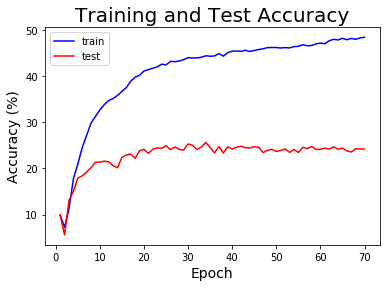

In [349]:
torch.manual_seed(10)
model = net.to(DEVICE)
optimizer = optim.SGD(params=model.parameters(), lr=config_info['lr'], momentum=config_info['momemtum'])
train(model, optimizer, train_loader, test_loader)
result = np.array(result, dtype=float)
np.savetxt(config_info['result_file'], result, fmt='%.2f', delimiter=',')
plot()

In [354]:
torch.save(model, "prithvi_cnn.pth")

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [218]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

In [223]:
clf = LogisticRegression(C=1.0)
clf.fit(x_train.reshape((-1, 12*180)), y_train)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [225]:
from sklearn.metrics import accuracy_score

In [227]:
predictions = clf.predict(x_test.reshape((-1, 12*180)))

# calculating accuracy on validation data
print('accuracy %s' % accuracy_score(y_test, predictions))

accuracy 0.1601597160603372


In [303]:
filename = 'logistics.sav'
joblib.dump(clf, filename)